# Import libraries

In [1]:
# Standard Library
import os
import sys
import subprocess
import random
import math
from math import floor
from collections import Counter

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Preprocessing and Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Statistical Analysis
import statsmodels.api as sm
import scipy.stats as stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Clustering
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained
from sklearn.decomposition import PCA

# Dimensionality Reduction
import umap

# Deep Learning
import tensorflow as tf
from tensorflow.keras import regularizers, Input, Model, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Module Utilities
import importlib.util

2024-12-12 13:24:44.653621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 13:24:44.654462: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:24:44.657490: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:24:44.665224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734006284.694314   20511 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734006284.70

In [2]:
# Get the current working directory and append the parent directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

# Add the parent directory to sys.path
sys.path.append(parent_directory)

In [3]:
from scripts.create_genotype import simulate_genos
from scripts.parse_vars import parse_variables
from scripts.calculate_true_maf_per_pop import calculate_true_maf_per_pop

# Parse variables

In [4]:
dict = parse_variables('params_geno_simul.txt')
if 'G' not in globals():
    G = int(dict['G'])
if 'L' not in globals():
    L = int(dict['L'])
if 'c' not in globals():
    c = int(dict['c'])
if 'k' not in globals():
    k = int(dict['k'])
if 'M' not in globals():
    M = float(dict['M'])

if 'very_rare_threshold_L' not in globals():
    very_rare_threshold_L = float(dict['very_rare_threshold_L'])
if 'very_rare_threshold_H' not in globals():
    very_rare_threshold_H = float(dict['very_rare_threshold_H'])
if 'rare_threshold_L' not in globals():
    rare_threshold_L = float(dict['rare_threshold_L'])
if 'rare_threshold_H' not in globals():
    rare_threshold_H = float(dict['rare_threshold_H'])
if 'common_threshold_L' not in globals():
    common_threshold_L = float(dict['common_threshold_L'])
if 'common_threshold_H' not in globals():
    common_threshold_H = float(dict['common_threshold_H'])

# Usefull functions

In [5]:
# Define a function to map values to colors
def map_to_color(x, y, z, df):
    # Check if there's variance to avoid division by zero
    r = x / df['x'].max() if df['x'].max() != 0 else 0  # Red component based on 'x'
    g = y / df['y'].max() if df['y'].max() != 0 else 0  # Green component based on 'y'
    b = z / df['z'].max() if df['z'].max() != 0 else 0  # Blue component based on 'z'
    
    return (r, g, b)

def reduce_reconstruct(block, n_components):
    scaler = StandardScaler()
    scaled_snps = scaler.fit_transform(block)
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_snps)
    
    # Reconstruction
    # Step 1: Inverse PCA transformation
    reconstructed_scaled_snps = pca.inverse_transform(reduced_data)
    
    # Step 2: Reverse scaling
    reconstructed_block = scaler.inverse_transform(reconstructed_scaled_snps)
    
    reconstructed_block = pd.DataFrame(
        data=reconstructed_block,
        columns=block.columns,
        index=block.index
    )
    return reconstructed_block

# Load data

In [6]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/"
humans = pd.read_pickle(f"{path_pheno}/inbred_humans.pkl")
humans['z'] = 0
complete = pd.read_pickle(f"{path_geno}/complete_inbred.pkl")

# Find inbreeding factor

In [7]:
try:
    true_p2s = pd.read_pickle(f"{path_geno}/true_p2s.pkl")
    true_twopqs = pd.read_pickle(f"{path_geno}/true_2pqs.pkl")
    true_q2s = pd.read_pickle(f"{path_geno}/true_q2s.pkl")
except:
    true_p2s, true_twopqs, true_q2s = calculate_true_maf_per_pop(complete, humans)
    true_p2s.to_pickle(f"{path_geno}/true_p2s.pkl")
    true_twopqs.to_pickle(f"{path_geno}/true_2pqs.pkl")
    true_q2s.to_pickle(f"{path_geno}/true_q2s.pkl")

In [8]:
true_ps = ((true_p2s - true_q2s)+1)/2
true_qs = 1-true_ps

In [9]:
true_inbreeding = 1-(true_twopqs/(2*true_ps*true_qs))

In [10]:
try:
    scaler = StandardScaler()
    scaled_complete = scaler.fit_transform(complete)
    n_components = max(min(complete.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_complete = pca.fit_transform(scaled_complete)
    PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

except:
    print("nothing in complete")
    PC_complete = pd.DataFrame(np.zeros((len(complete), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [11]:
PC_complete['inbreeding'] = true_inbreeding.mean(axis = 1)

<Axes: xlabel='PC1', ylabel='PC2'>

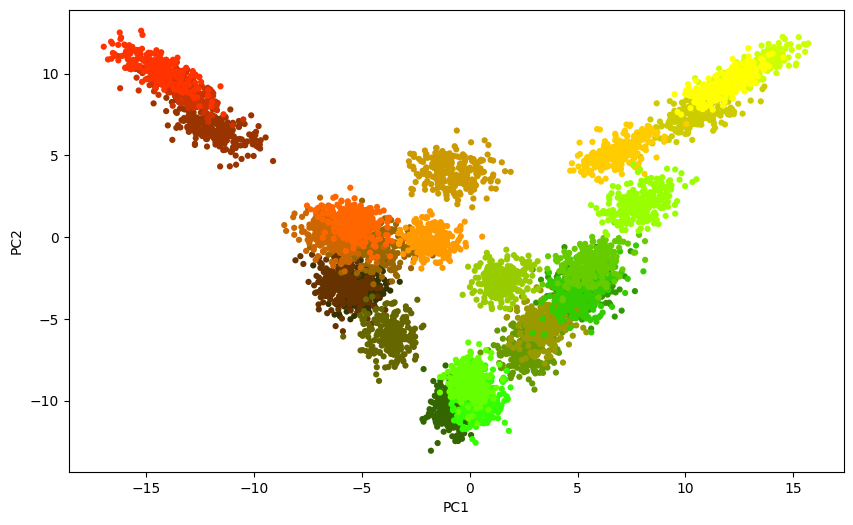

In [12]:
plt.figure(figsize=(10, 6))
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]

# First scatter plot
sns.scatterplot(
    data=PC_complete,
    x="PC1",
    y="PC2",  # Set color for this dataset
    s=20,          # Adjust point size
    linewidth=0, # Adjust edge width
    edgecolor="black",
    c=colors
    # Set edge color
)


<Axes: xlabel='PC1', ylabel='PC2'>

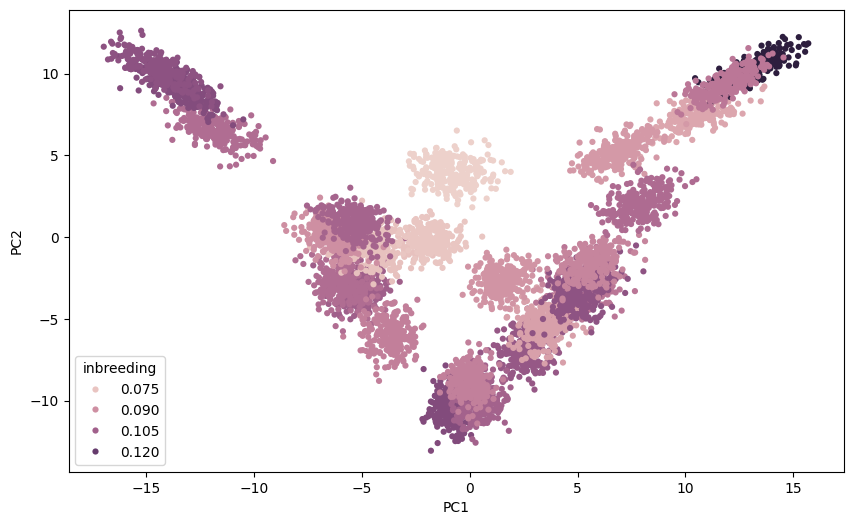

In [13]:
plt.figure(figsize=(10, 6))

# First scatter plot
sns.scatterplot(
    data=PC_complete,
    x="PC1",
    y="PC2",  # Set color for this dataset
    s=20,          # Adjust point size
    linewidth=0, # Adjust edge width
    edgecolor="black",
    hue="inbreeding"
    # Set edge color
)


# Load LD blocks

In [14]:
majs_rec = []
het_rec = []
min_rec = []

MAF_blocks = [f for f in os.listdir(f"{path_geno}/LD_blocks") if f.startswith('block')]
for MAF_block in MAF_blocks:
    path_maf_block = f"{path_geno}/LD_blocks/{MAF_block}"
    for ld_block in [f for f in os.listdir(path_maf_block) if f.startswith('block')]:
        path_ld_block = f"{path_maf_block}/{ld_block}"
        block = pd.read_pickle(path_ld_block)
         # Update minor allele mapping
        db_minor = block.copy()
        db_minor = db_minor.map(lambda x: 1 if x == -1.0 else 0)
        
        # Update heterozygous allele mapping
        db_het = block.copy()
        db_het = db_het.map(lambda x: 1 if x == 0.0 else 0)
        
        # Update major allele mapping
        db_major = block.copy()
        db_major = db_major.map(lambda x: 1 if x == 1.0 else 0)
        n_components = 5
        db_major_rec = reduce_reconstruct(db_major, n_components)
        db_minor_rec = reduce_reconstruct(db_minor, n_components)
        db_het_rec = reduce_reconstruct(db_het, n_components)
        majs_rec.append(db_major_rec)
        het_rec.append(db_het_rec)
        min_rec.append(db_minor_rec)

In [15]:
majs_rec_concated = pd.concat(majs_rec, axis =1)
majs_rec_concated = majs_rec_concated[complete.columns]

het_rec_concated = pd.concat(het_rec, axis =1)
het_rec_concated = het_rec_concated[complete.columns]

mins_rec_concated = pd.concat(min_rec, axis =1)
mins_rec_concated = mins_rec_concated[complete.columns]

In [16]:
esti_ps = ((majs_rec_concated - mins_rec_concated)+1)/2
esti_qs = 1-esti_ps

esti_inbreeding = 1-(het_rec_concated/(2*esti_ps*esti_qs))

In [17]:
PC_complete['estimated inbreeding'] = abs(esti_inbreeding.mean(axis = 1))

In [18]:
PC_complete

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,inbreeding,estimated inbreeding
0,-4.594860,-2.400075,-17.153348,0.862071,1.888498,-3.098411,-2.307664,-0.104623,-1.345887,-0.737095,...,1.139741,1.435818,0.299591,-0.087145,-0.162421,1.131343,1.754197,-1.359863,0.105296,0.258451
1,-5.477128,-3.626247,-21.349742,1.031064,1.401678,-2.891597,-1.405924,-0.609131,-0.917632,-0.599228,...,-2.287551,-0.277642,-0.673688,0.532603,-1.238196,0.186676,-1.059733,-0.178207,0.105296,0.035264
2,-4.695387,-3.613369,-17.960434,0.568087,1.554671,-2.106027,-0.682648,-0.301326,-0.667845,0.429095,...,-0.443262,1.228236,1.096354,-1.324952,2.087856,-1.388658,1.967743,0.609095,0.105296,0.092981
3,-5.912512,-2.051359,-20.185346,1.955066,1.298401,-3.427277,-1.143359,-0.285022,-1.019621,-0.926703,...,0.343361,-0.134961,-0.303503,-1.516564,-1.326309,0.209209,0.286657,0.961433,0.105296,2.397680
4,-5.541416,-2.653908,-21.527023,1.038892,1.248580,-3.879219,-0.269325,0.257738,-0.155119,-1.700196,...,0.535439,-1.313189,-1.851569,-0.100056,0.612657,-0.391063,-0.721787,0.343752,0.105296,0.240630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6245,12.497771,9.636552,-2.838248,-0.306696,-2.316828,6.801284,0.797214,-4.644872,-0.922402,-2.279155,...,0.119858,0.988670,-1.728776,-1.543693,-0.560294,-0.422925,0.113557,-0.640472,0.097147,0.032398
6246,13.549624,10.878349,-2.548296,0.209013,-0.593920,8.039704,1.033776,-5.462223,-2.726316,-0.329811,...,2.180399,-2.127185,0.812820,0.179734,1.837839,2.710059,-0.233294,-1.429492,0.097147,0.889645
6247,12.082747,9.053880,-2.790450,1.958798,-0.211691,7.511557,2.584285,-7.322192,-3.871626,-0.863253,...,-1.427092,0.957044,-0.338016,-0.155522,-0.588190,-1.165312,0.212636,0.365047,0.097147,0.283018
6248,10.635196,7.924901,-1.144587,1.769907,-1.190823,4.794435,-0.228840,-3.385148,-1.615513,-0.105619,...,-2.425798,1.954308,-0.305294,-0.841313,1.404112,-1.252623,-0.238064,1.829128,0.097147,0.365665


In [19]:
sorted_df = PC_complete.sort_values(by="estimated inbreeding", ascending=False)

<Axes: xlabel='PC1', ylabel='PC2'>

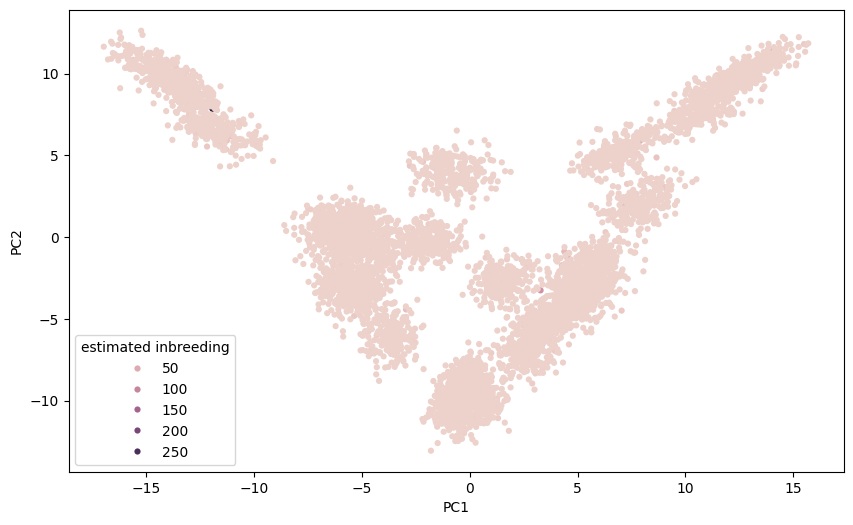

In [20]:
plt.figure(figsize=(10, 6))

# First scatter plot
sns.scatterplot(
    data=sorted_df,
    x="PC1",
    y="PC2",  # Set color for this dataset
    s=20,          # Adjust point size
    linewidth=0, # Adjust edge width
    edgecolor="black",
    hue="estimated inbreeding"
    # Set edge color
)


In [21]:
def find_Pxy(ps):
    # Compute the mean of each row
    twopq = 2*ps*(1-ps)
    row_means = twopq.mean(axis=1).values  # Convert to a numpy array
    
    # Create a symmetric matrix of pairwise averages
    symmetric_matrix = 0.5 * (row_means[:, np.newaxis] + row_means[np.newaxis, :])
    
    # Convert to DataFrame
    Pxy = pd.DataFrame(symmetric_matrix, index=twopq.index, columns=twopq.index)
    return Pxy

def find_Dxy(ps):
    ps_values = ps.values
    # Compute the pairwise differences
    complement = 1 - ps_values  # Precompute the complements
    Dxy_matrix = (
        (ps_values @ complement.T) + (complement @ ps_values.T)
    ) / ps_values.shape[1]
    
    # Convert to DataFrame for easier handling
    Dxy = pd.DataFrame(Dxy_matrix, index=ps.index, columns=ps.index)
    return Dxy

def find_Dxy_element_wise(Ps):
    n = len(Ps)
    symmetric_matrix = np.zeros((n, n))
    
    # Iterate over rows to calculate Pxy
    for i, (pop1, row1) in enumerate(Ps.iterrows()):
        for j, (pop2, row2) in enumerate(Ps.iterrows()):
            if j >= i:  # Only compute for upper triangle and diagonal
                Dxy = (row1 * (1 - row2) + (1-row1)*row2).mean()
                symmetric_matrix[i, j] = Dxy
                symmetric_matrix[j, i] = Dxy  # Fill the symmetric position
    # Convert to DataFrame for easier handling
    Dxy = pd.DataFrame(symmetric_matrix, index=Ps.index, columns=Ps.index)
    return Dxy

# Find Hudson's Fst

In [22]:
try:
    Pxy = pd.read_pickle(f"{path_pheno}/Pxy_true.pkl")
    Dxy = pd.read_pickle(f"{path_pheno}/Dxy_true.pkl")
except:
    Pxy = find_Pxy(true_ps)
    Pxy.to_pickle(f"{path_pheno}/Pxy_true.pkl")
    
    Dxy = find_Dxy(true_ps)
    Dxy.to_pickle(f"{path_pheno}/Dxy_true.pkl")
    

In [23]:
Fst_true = (Dxy - Pxy)/Dxy
Fst_true = Fst_true.round(5)

In [24]:
import umap
# Convert dissimilarity to distances if required
reducer = umap.UMAP(metric='precomputed', random_state=42)
embeddings = reducer.fit_transform(Fst_true)
humans[['dim1_true', 'dim2_true']] = embeddings

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


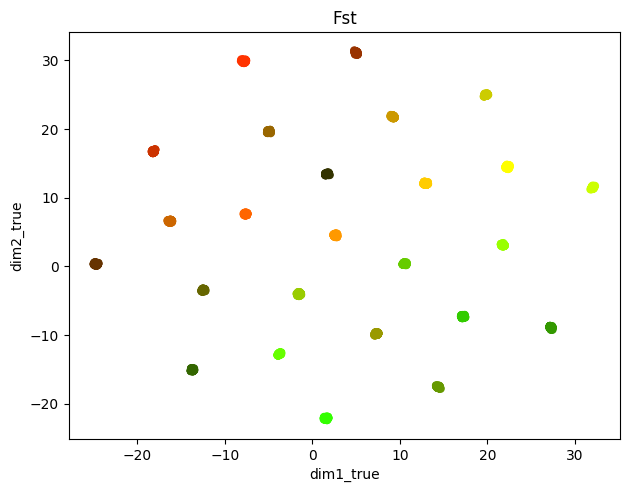

In [25]:
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
sns.scatterplot(x='dim1_true', y='dim2_true', data=humans, color=colors, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Fst")
# Show the plots
plt.show()
plt.close()

In [26]:
try:
    Pxy = pd.read_pickle(f"{path_pheno}/Pxy_esti.pkl")
    Dxy = pd.read_pickle(f"{path_pheno}/Dxy_esti.pkl")
except:
    Pxy = find_Pxy(esti_ps)
    Pxy.to_pickle(f"{path_pheno}/Pxy_esti.pkl")
    
    Dxy = find_Dxy(esti_ps)    
    Dxy.to_pickle(f"{path_pheno}/Dxy_esti.pkl")

In [27]:
Fst_esti = (Dxy - Pxy)/Dxy
Fst_esti = Fst_esti.round(5)

In [28]:
# Convert dissimilarity to distances if required
reducer = umap.UMAP(metric='precomputed', random_state=42)
embeddings = reducer.fit_transform(Fst_esti)
humans[['dim1_esti', 'dim2_esti']] = embeddings

/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/mat2m10/.pyenv/versions/3.10.6/envs/pop_esti/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


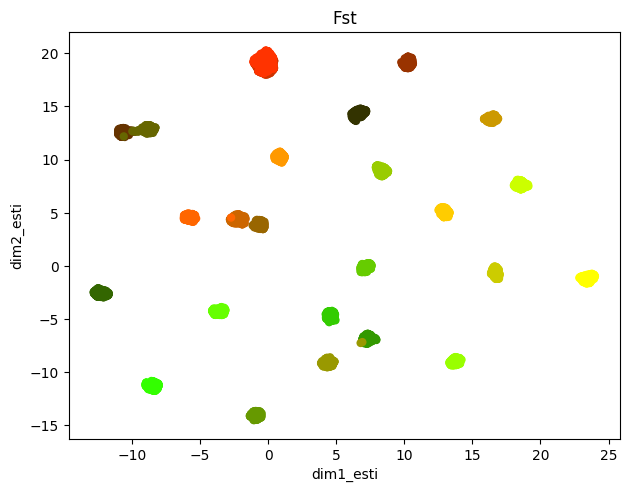

In [29]:
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
sns.scatterplot(x='dim1_esti', y='dim2_esti', data=humans, color=colors, linewidth=0)

# Adjust layout
plt.tight_layout()
plt.title(f"Fst")
# Show the plots
plt.show()
plt.close()

# per segment

In [30]:
"""
path_blocks = f"{path_pheno}/blocks/"
os.makedirs(path_blocks,exist_ok = True)
for i_majs in range(len(majs_rec))[0:2]:
    esti_ps = ((majs_rec[i_majs] - min_rec[i_majs])+1)/2
    esti_inbreeding = 1-(het_rec[i_majs]/(2*esti_ps*(1-esti_ps)))
    temp_humans = humans[['populations','x','y','z']]
    temp_humans['inbreeding'] = esti_inbreeding.mean(axis=1)
    temp_humans.to_pickle(f"{path_blocks}/inbreeding_block_{i_majs}")
    try:
        Pxy = pd.read_pickle(f"{path_blocks}/Pxy_esti_block_{i_majs}.pkl")
        Dxy = pd.read_pickle(f"{path_blocks}/Dxy_esti_block_{i_majs}.pkl")
    except:
        # Compute the mean of each row
        twopq = 2*esti_ps*(1-esti_ps)
        row_means = twopq.mean(axis=1).values  # Convert to a numpy array
        
        # Create a symmetric matrix of pairwise averages
        symmetric_matrix = 0.5 * (row_means[:, np.newaxis] + row_means[np.newaxis, :])
        
        # Convert to DataFrame
        Pxy = pd.DataFrame(symmetric_matrix, index=twopq.index, columns=twopq.index)
        Pxy.to_pickle(f"{path_blocks}/Pxy_esti_block_{i_majs}.pkl")
    
        
        n = len(esti_ps)
        symmetric_matrix = np.zeros((n, n))
        
        # Iterate over rows to calculate Pxy
        for i, (pop1, row1) in enumerate(esti_ps.iterrows()):
            for j, (pop2, row2) in enumerate(esti_ps.iterrows()):
                if j >= i:  # Only compute for upper triangle and diagonal
                    Dxy = (row1 * (1 - row2) + (1-row1)*row2).mean()
                    symmetric_matrix[i, j] = Dxy
                    symmetric_matrix[j, i] = Dxy  # Fill the symmetric position
        # Convert to DataFrame for easier handling
        Dxy = pd.DataFrame(symmetric_matrix, index=esti_ps.index, columns=esti_ps.index)
        Dxy.to_pickle(f"{path_blocks}/Dxy_esti_block_{i_majs}.pkl")

"""

'\npath_blocks = f"{path_pheno}/blocks/"\nos.makedirs(path_blocks,exist_ok = True)\nfor i_majs in range(len(majs_rec))[0:2]:\n    esti_ps = ((majs_rec[i_majs] - min_rec[i_majs])+1)/2\n    esti_inbreeding = 1-(het_rec[i_majs]/(2*esti_ps*(1-esti_ps)))\n    temp_humans = humans[[\'populations\',\'x\',\'y\',\'z\']]\n    temp_humans[\'inbreeding\'] = esti_inbreeding.mean(axis=1)\n    temp_humans.to_pickle(f"{path_blocks}/inbreeding_block_{i_majs}")\n    try:\n        Pxy = pd.read_pickle(f"{path_blocks}/Pxy_esti_block_{i_majs}.pkl")\n        Dxy = pd.read_pickle(f"{path_blocks}/Dxy_esti_block_{i_majs}.pkl")\n    except:\n        # Compute the mean of each row\n        twopq = 2*esti_ps*(1-esti_ps)\n        row_means = twopq.mean(axis=1).values  # Convert to a numpy array\n        \n        # Create a symmetric matrix of pairwise averages\n        symmetric_matrix = 0.5 * (row_means[:, np.newaxis] + row_means[np.newaxis, :])\n        \n        # Convert to DataFrame\n        Pxy = pd.DataFra

# Matrix computation but can break

In [31]:
path_blocks = f"{path_pheno}/blocks/"
os.makedirs(path_blocks,exist_ok = True)
for i_majs in range(len(majs_rec)):
    esti_ps = ((majs_rec[i_majs] - min_rec[i_majs])+1)/2
    esti_inbreeding = 1-(het_rec[i_majs]/(2*esti_ps*(1-esti_ps)))
    temp_humans = humans[['populations','x','y','z']]
    temp_humans['inbreeding'] = abs(esti_inbreeding.mean(axis=1))
    temp_humans.to_pickle(f"{path_blocks}/inbreeding_block_{i_majs}")
    try:
        Pxy = pd.read_pickle(f"{path_blocks}/Pxy_esti_block_{i_majs}.pkl")
        Dxy = pd.read_pickle(f"{path_blocks}/Dxy_esti_block_{i_majs}.pkl")
    except:

        Pxy = find_Pxy(esti_ps)
        Pxy.to_pickle(f"{path_blocks}/Pxy_esti_block_{i_majs}.pkl")
    
        Dxy = find_Dxy(esti_ps)    
        Dxy.to_pickle(f"{path_blocks}/Dxy_esti_block_{i_majs}.pkl")

/tmp/ipykernel_20511/422267033.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans['inbreeding'] = abs(esti_inbreeding.mean(axis=1))
/tmp/ipykernel_20511/422267033.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_humans['inbreeding'] = abs(esti_inbreeding.mean(axis=1))
/tmp/ipykernel_20511/422267033.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation